In [2]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy import interpolate
import cv2 as cv
import os

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch

from data import download_all_data

CUR_DIR = os.path.abspath('')

# Dataset


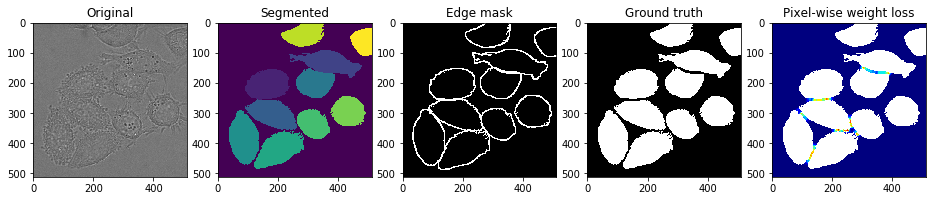

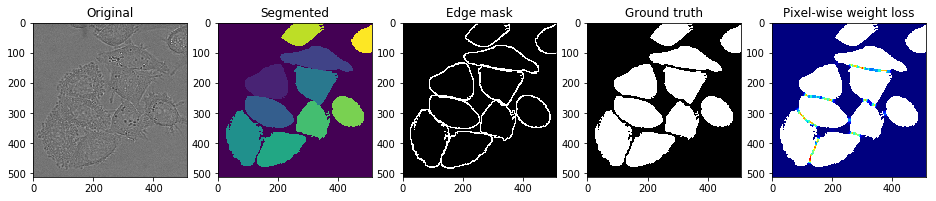

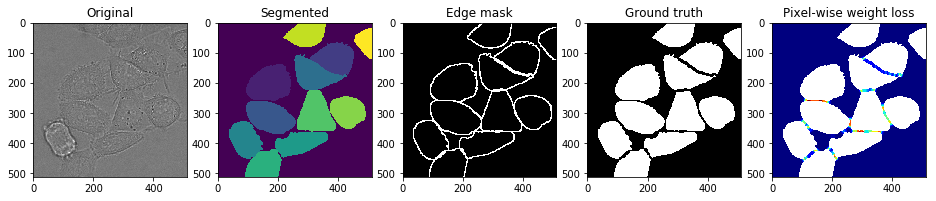

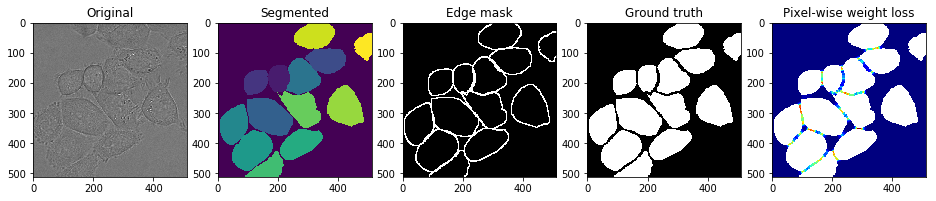

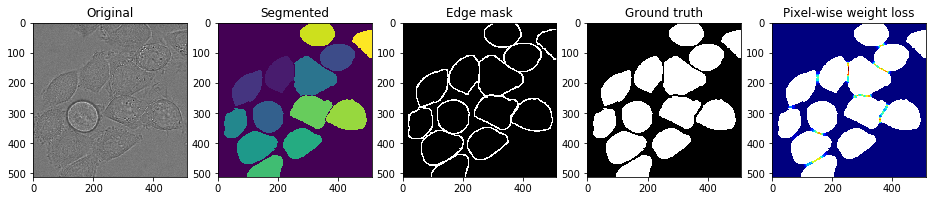

In [3]:
def preprocess_gt(img):
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
    mask_global = np.zeros(img.shape)
    for cls in np.unique(img):
        if cls == 0:  # if not a background
            continue
        mask_cls = np.zeros(img.shape)
        mask_cls[img==cls] = 255  # binary image of cell
        dilated = cv.dilate(mask_cls, kernel, iterations=2)
        mask_global += dilated-mask_cls  # add edge to global mask
#         mask += cv.erode(dilated-thresh,kernel2,iterations=1) 
#         mask +=  cv.morphologyEx(dilated-thresh, cv.MORPH_OPEN, kernel)
    
    gt = img - mask_global # edges of cells will be background on the new ground truth
    gt[gt<0] = 0  # clipping
    
    return gt, mask_global

# Download data
download_all_data()

# Specify which dataset to analyse
# DATASET = 'PhC-C2DH-U373'
# DATASET = 'ISBI2012'
DATASET = 'DIC-C2DH-HeLa'

target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")
target = os.listdir(target_path)
# for i in range(len(target)):
for i in range(5):
    # load images
    img = cv.imread(os.path.join(target_path, target[i]), -1)
    img_og = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"))
    
    
    # image morphology, for edge detection (ONLY FOR DIC-C2DH-HeLa, since cells intersect)
    gt, mask_global = preprocess_gt(img)
    if DATASET != "DIC-C2DH-HeLa":
        gt = img
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_og)
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img)
    plt.title('Segmented')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(gt_bin, cmap='gray')
    plt.title('Ground truth')
    
    # Calculating loss for ground truth
    wc = np.zeros(img.shape)
    for cls in np.unique(img):
        s = np.sum(img==cls)
        wc[gt==cls] = 1/s
    wc = wc / np.max(wc)  # normalize
    
    w0 = 10
    sigma = 5
    d1 = img.shape[0]*img.shape[1]*np.ones(img.shape)
    d2 = np.zeros(img.shape)

    dsts = []
    for cls in np.unique(img)[1:]:
        new_bin = np.zeros(img.shape)
        a = gt!=cls
        b = gt!=0
        new_bin[a & b] = 255
        gt_bin = 255-new_bin.astype(np.uint8)
        dst = cv.distanceTransform(src=gt_bin, distanceType=cv.DIST_L2, maskSize=3)
        d1 = np.minimum(d1, dst)
        d2 = np.maximum(d2, dst)
    
    loss_img = wc + w0*np.exp(-(d1+d2)**2 / (2*sigma**2))
    loss_img[gt > 0] = np.nan  # cells dont have loss (or loss=0?)
    
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    
    plt.title("Pixel-wise weight loss")
    plt.show()

# Data Augmentation

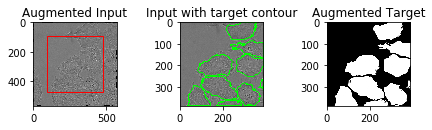

In [9]:
def elastic_transform(images, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       source: https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
    """

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = images[0].shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # TODO: change to bicubic interpolation
    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))
        
    return (map_coordinates(image, indices, order=1).reshape(shape) for image in images)

def mirror_transform(image):
    new_image = np.zeros((572, 572))
    new_image[92:92+388, 92: 92+388] = image
    new_image[:92, 92:92 + 388] = image[92:0:-1, 0:388]  # left side
    new_image[:92, :92] = new_image[0:92, 92+92:92:-1]  # top left
    new_image[:92, 92+388:] = new_image[0:92, 388+91:388-1:-1]  # bot left
    new_image[388+92:, 92:92 + 388] = image[388:388-93:-1, 0:388]  # right side
    new_image[388+92:, :92] = new_image[388+92:, 92+92:92:-1]  # top right
    new_image[388+92:, 388+92:] = new_image[388+92:, 388+91:388-1:-1]  # bot right
    new_image[92:388+92, 0:92] = image[:, 92:0:-1] # top side
    new_image[92:388+92, 388+92:] = image[:, 388-1:388-1-92:-1]  # bot side
    return new_image

class ImageDataset(Dataset):
    def __init__(self, root_dir, alpha=3, sigma=10):
        self.root_dir = root_dir
        self.alpha = alpha
        self.sigma = sigma

        self.image = []
        self.target = []

        n = len(os.listdir(root_dir)) // 3
        for i in range(1, n+1):
            image_folder = os.path.join(root_dir, f"0{i}")
            target_folder = os.path.join(os.path.join(root_dir, f"0{i}_GT", "SEG"))
            image_names = [filename.replace('man_seg', 't') for filename in os.listdir(target_folder)]
            self.image.extend(cv.imread(os.path.join(image_folder, image_name), -1) for image_name in image_names)
            
            for filename in os.listdir(target_folder):
                img = cv.imread(os.path.join(target_folder, filename), -1)
                gt, _ = preprocess_gt(img)
                _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
                self.target.append(gt_bin)

    def __len__(self):
        return 4*len(self.image)

    def __getitem__(self, idx):
        i = idx // 4
        x = (512-388)*(idx % 2)
        y = (512-388)*((idx-4*i) // 2)
        image = mirror_transform(self.image[i][x:x+388, y:y+388])
        target = mirror_transform(self.target[i][x:x+388, y:y+388])
        inp, gt = elastic_transform((image, target), alpha=self.alpha, sigma=self.sigma)
        gt = gt[92:388+92, 92:388+92]
        return transforms.ToTensor()(inp.astype('float64')), \
               transforms.ToTensor()(gt.astype('float64'))


# init ImageDataset
root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
transformed_dataset = ImageDataset(root_dir, alpha=250, sigma=10)
val_per = 0.3
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [int(len(transformed_dataset) * (1-val_per)), int(len(transformed_dataset) * val_per)+1])

# visualise augmentation
for i in range(1):
    img, gt = transformed_dataset[i]
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.imshow(img.reshape(img.shape[1:]), cmap='gray')
    rect = patches.Rectangle((92,92),388,388,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax1.add_patch(rect)
    ax1.set_title("Augmented Input")

    gt = gt.reshape(gt.shape[1:]).numpy().astype(np.uint8)
    contours, hierarchy = cv.findContours(gt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.cvtColor(img.reshape(img.shape[1:])[92:92+388,92:92+388].numpy().astype(np.uint8),cv.COLOR_GRAY2RGB)
    cv.drawContours(image, contours, -1, (0, 255, 0), 3)
    ax2.imshow(image)
    ax2.set_title("Input with target contour")

    ax3.imshow(gt, cmap='gray')
    ax3.set_title("Augmented Target")
    fig.tight_layout()
    plt.show()

# init DataLoader
data_loader = DataLoader(transformed_dataset, batch_size=4, shuffle=True)

In [5]:
# init ImageDataset


In [10]:
from trainer import training
from network import Unet

root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
transformed_dataset = ImageDataset(root_dir, alpha=250, sigma=10)
val_per = 0.3
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [int(len(transformed_dataset) * (1-val_per)), int(len(transformed_dataset) * val_per)+1])

# init DataLoader
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

unet = Unet()
training(unet, train_loader, epochs=1, batch_size=1)

BATCH START


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat1' in call to _th_addmm_

In [8]:
print(train_loader)
print(len(train_loader))
print(dir(train_loader))
print(train_loader)
for batch in train_loader: # get batch
    print(batch)
    break

13
['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_index_sampler', 'batch_sampler', 'batch_size', 'collate_fn', 'dataset', 'drop_last', 'multiprocessing_context', 'num_workers', 'pin_memory', 'sampler', 'timeout', 'worker_init_fn']
[tensor([[[[  0.0000,   0.0000,   0.0000,  ..., 123.3650, 125.5546, 122.0847],
          [  0.0000,   0.0000,   0.0000,  ..., 125.3170, 125.6619, 122.1662],
          [  0.0000,   0.0000,   0.0000,  ..., 122.6069, 119.9811, 111.0320],
          ...,
          [104.0189, 106.9551, 111.5256,  ..., 127.4397, 130.